In [7]:
# Load the NG data and the response function and dump output into variables
from IPython.utils import io
with io.capture_output() as output_03:
    %run '03_2d_spectra.ipynb'
with io.capture_output() as output_05:
    %run '05_response function.ipynb'

In [10]:
# You can execute one of these lines if you want to view the output of these scripts
#output_03()
#output_05()

In [110]:
x1 = np.array(x1)
x2 = np.array(x2)
x3 = np.array(x3)
x4 = np.array(x4)
f1 = np.array(f1)
f2 = np.array(f2)
f3 = np.array(f3)
f4 = np.array(f4)

In [ ]:
def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

def get_neutron_spectrum(mu, sigma):
    '''
    Get the smeared version of the response for an original neutron spectrum that is Gaussian in energy.
    Mu and sigma in MeV please.
    '''
    
    smeared_response = np.zeros(len(electron_energies))
    for i in range(len(neutron_energies) - 1):
        # Current neutron energy
        neutron_energy = neutron_energies[i]
        # Current bin width. Maybe drop?
        bin_width = neutron_energies[i+1] - neutron_energies[i]
        ampl = gaussian(neutron_energy, mu, sigma)
        #print(neutron_energy, bin_width, ampl)
        smeared_response += ampl*response[i]
    return smeared_response

This is just a little example of how good or bad the data looks.

For a proper analysis, we need:
  * A proper rescaling of the electron energy scale. Right now, it's just based on the half max point.
  * A proper fit of the spectrum instead of just a 'guess values and compare'
  * A better signal model than only a Gaussian spectrum.
  * A small 14 TeV contribution?
  * Background subtraction
  * Acceptance estimate (Current method: la guess based on how the spectra look).

/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


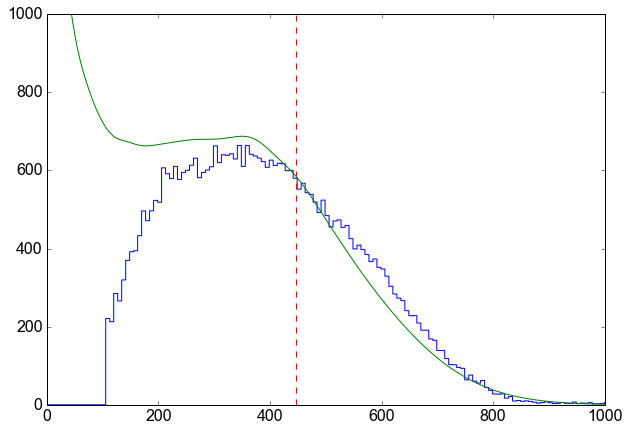

In [108]:
# Plot the distribution for 4 different binning settings
# plt.plot(x1, 1/1*np.array(f1))
# plt.plot(x2, 1/2*np.array(f2))
plt.plot(x3, 1/3*np.array(f3), ls='steps')
# plt.plot(x4, 1/4*np.array(f4), ls='steps')
plt.axvline(x1[200], color='red', ls='--') # 200 channels is about 450 keVee
plt.xlim(0,1000)

for e in [2, 2.1, 2.2, 2.3, 2.4, 2.5]:
    
    sample = np.argmin(abs(neutron_energies - e))
    energy = neutron_energies[sample]
    ad_hoc_scale = 8000
    #plt.plot(1000*electron_energies, ad_hoc_scale*response[sample], label='Energy = %.2f MeV' % energy)

plt.plot(1000*electron_energies, 100*get_neutron_spectrum(2.25,0.3)
         )

plt.ylim(0,1000)
plt.legend()

In [209]:
fit_range = [450, 900]

sel_data = (x3 > fit_range[0]) & (x3 < fit_range[1])
sel_fit  = ((1000*electron_energies) > fit_range[0]) &  ((1000*electron_energies) < fit_range[1])

# Select data piece to fit
x = x3[sel_data]
y_data = f3[sel_data]
y_err = np.sqrt(y_data)

def get_chi_sq(y_data, y_err, y_fit):
    return sum((y_fit - y_data)**2/(y_err**2)) / len(y_data)

def get_y_fit(mu, sigma):
    return np.interp(x3[sel_data],1000*electron_energies,get_neutron_spectrum(mu, sigma))
def get_y_fit_full(mu, sigma):
    return np.interp(x3,1000*electron_energies,get_neutron_spectrum(mu, sigma))


best_mu = 0.
best_sigma = 0.
best_chi2 = np.inf
best_scale = 0.

# Worst minimizer routine EVER: just loop over all values :)
# Oh, and just to add to this: the scaling is just estimated based on same number of events
for mu in np.arange(2.3,2.5, 0.01):
    for sigma in np.arange(0.15,0.25,0.01):
        y_fit = get_y_fit(mu, sigma)
        scale_guess = sum(y_data)/sum(y_fit)
        if (get_chi_sq(y_data, y_err, scale_guess*y_fit)) < best_chi2:
            best_mu = mu
            best_sigma = sigma
            best_y_fit = scale_guess*y_fit
            best_scale = scale_guess
            best_chi2 = (get_chi_sq(y_data, y_err, scale_guess*y_fit))

print(best_mu)
print(best_sigma)

2.36
0.19


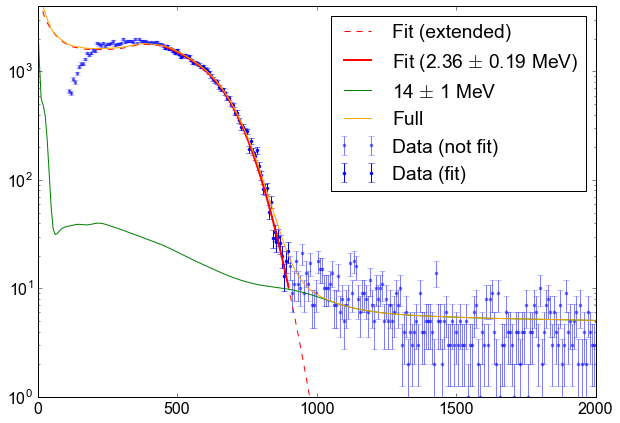

In [240]:
# Plot data outside range
plt.errorbar(x3[np.invert(sel_data)], f3[np.invert(sel_data)], np.sqrt(f3[np.invert(sel_data)]),
            ls='None', marker='.', alpha=0.5, color='blue', label='Data (not fit)')
#
plt.errorbar(x, y_data, y_err, ls='None', marker='.', label='Data (fit)')

plt.plot(x3, best_scale*get_y_fit_full(best_mu, best_sigma), ls='--', color='red', label='Fit (extended)')
plt.plot(x, best_y_fit, color='red', lw=2, label='Fit (%.2f $\pm$ %.2f MeV)' % (best_mu, best_sigma))

# 14 MeV guess
plt.plot(x3, 80*get_y_fit_full(14,1.),label='14 $\pm$ 1 MeV')

plt.plot(x3, best_scale*get_y_fit_full(best_mu, best_sigma) + 80*get_y_fit_full(14,1.),
         label='Full', color='orange')


plt.xlim(0,2000)
plt.yscale('log')
plt.ylim(1,4*10**3)
plt.legend()